# Generative Model (Olive Oils dataset)

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [9]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import models as mdl
import utils as utl
from data import Data

## Load raw data and plot

In [10]:
# init data object
data_obj = Data('../../data/olive_oils/FTIR_olive_oils.csv', 'label', -3)
data = data_obj.data
data.head(5)

,798.892,800.8215,802.751,804.6805,806.61,808.5395,810.469,812.3985,814.328,816.2575,...,1885.2305,1887.16,1889.0895,1891.019,1892.9485,1894.878,1896.8085,code,label,sample
44,0.127147,0.127587,0.129321,0.131166,0.133155,0.135617,0.138395,0.140899,0.143519,0.145796,...,0.003791,0.003540,0.003430,0.003345,0.003275,0.003094,0.002959,2,Italy,23
47,0.126618,0.127110,0.128289,0.130156,0.132573,0.135221,0.137872,0.140590,0.142919,0.144947,...,0.006713,0.006519,0.006012,0.005937,0.005862,0.005570,0.005606,2,Italy,24
4,0.128602,0.128790,0.130022,0.132012,0.134427,0.137070,0.139646,0.142338,0.144923,0.146958,...,0.010594,0.010379,0.010287,0.010127,0.009966,0.009760,0.009649,1,Greece,3
55,0.128149,0.128600,0.130136,0.132407,0.135488,0.138501,0.141224,0.144109,0.146412,0.148171,...,0.010286,0.010086,0.009620,0.009541,0.009713,0.009405,0.009267,3,Portugal,28
26,0.128867,0.129291,0.130672,0.132708,0.135109,0.137758,0.140860,0.143611,0.145792,0.147613,...,0.007027,0.006848,0.006511,0.006470,0.006405,0.006071,0.005872,2,Italy,14


Greece: blue
Italy: red
Portugal: green
Spain: orange


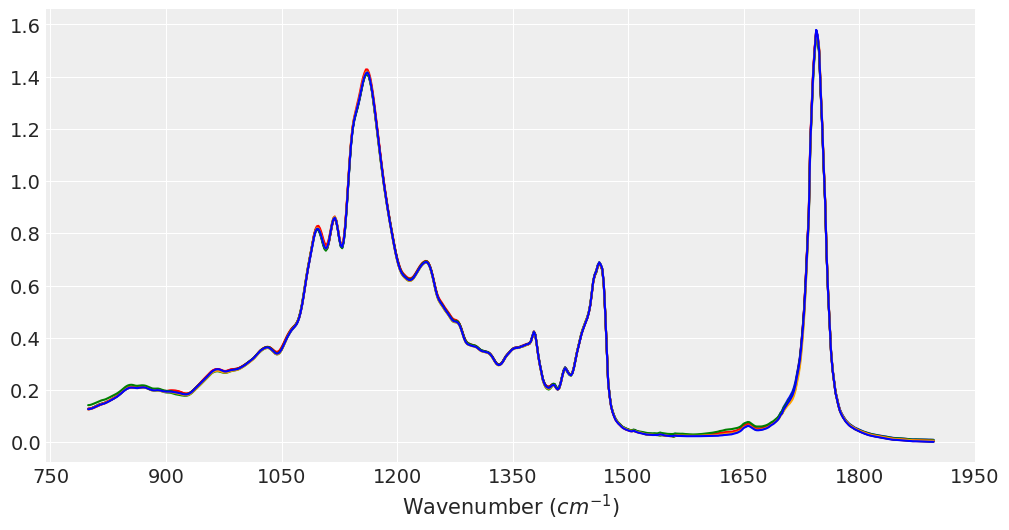

In [11]:
# name of column containing the labels
label_col = data_obj.label_column

# number of non-data columns at right of dataframe
non_data_cols = data_obj.non_data_columns

# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 8)

In [12]:
# number of samples from each class
data[label_col].value_counts()

Spain       50
Italy       34
Greece      20
Portugal    16
Name: label, dtype: int64

In [13]:
# store the data values for all different classes
df = [data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

x_n = data.columns[:non_data_cols]
x_s = [df[i][x_n].values for i in range(len(df))]

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a..d} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [14]:
# load model and run inference
nsamples = 16
genmod = mdl.generative_model(x_s, len(class_labels), len(x_n), nsamples=nsamples)

with genmod:
    trace_gm = pm.sample(2000, init='adapt_diag', tune=1000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [01:09<00:00, 86.61draws/s] 


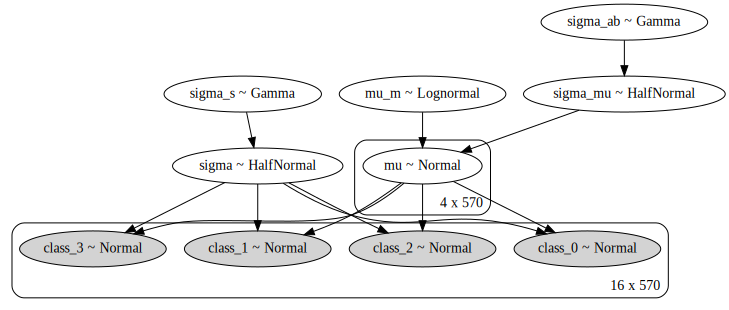

In [15]:
pm.model_to_graphviz(genmod)

In [16]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",0.128,0.001,0.126,0.129,0.000,0.000,7752.0,7744.0,7746.0,2986.0,1.00
"mu[0,1]",0.128,0.001,0.126,0.129,0.000,0.000,5628.0,5628.0,5672.0,2532.0,1.00
"mu[0,2]",0.129,0.001,0.128,0.131,0.000,0.000,6182.0,6182.0,6180.0,3104.0,1.00
"mu[0,3]",0.131,0.001,0.129,0.133,0.000,0.000,7304.0,7304.0,7319.0,2736.0,1.01
"mu[0,4]",0.134,0.001,0.132,0.135,0.000,0.000,7760.0,7760.0,7783.0,2876.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,0.334,0.007,0.321,0.347,0.000,0.000,5687.0,5686.0,5663.0,2406.0,1.00
sigma_ab,0.757,0.630,0.118,1.896,0.011,0.008,3390.0,2953.0,5759.0,2665.0,1.00
sigma_mu,0.334,0.005,0.325,0.344,0.000,0.000,5831.0,5808.0,5885.0,2309.0,1.00
sigma_s,0.204,0.422,0.001,0.875,0.007,0.005,3391.0,3379.0,5036.0,3128.0,1.00


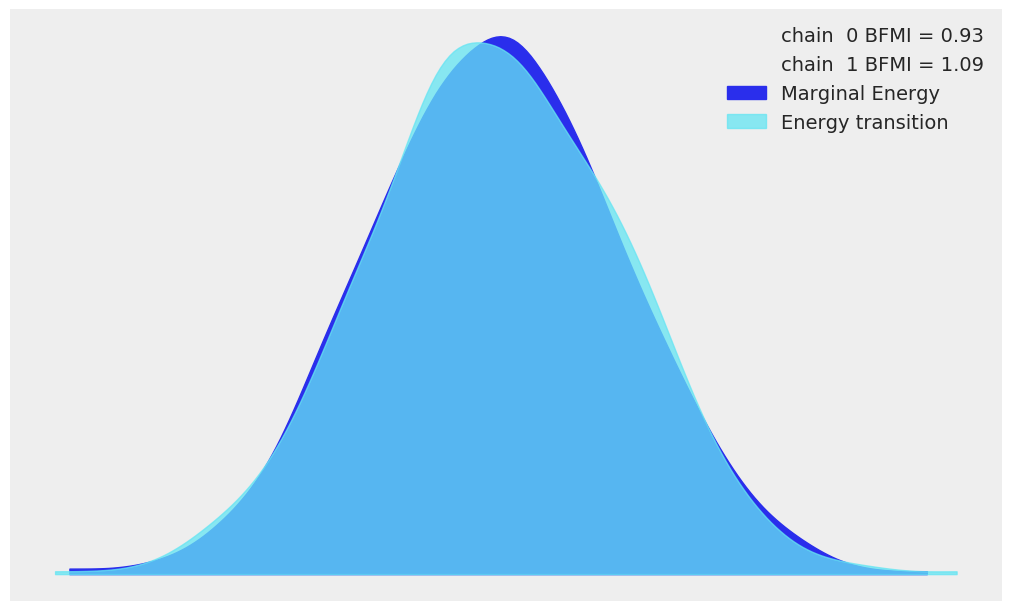

In [17]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [18]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=genmod)

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 250/250 [00:02<00:00, 105.38it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


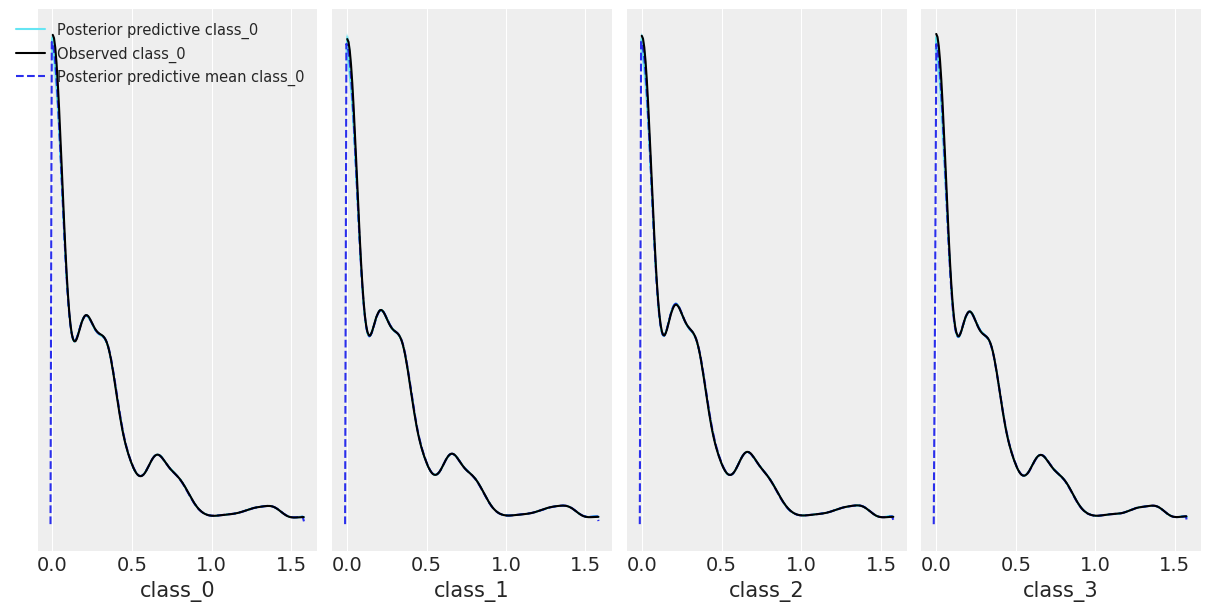

In [19]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [20]:
print(az.r2_score(x_s[0][:nsamples], ppc['class_0']))

r2        0.999882
r2_std    0.000011
dtype: float64


In [22]:
print(az.r2_score(x_s[1][:nsamples], ppc['class_1']))

r2        0.999883
r2_std    0.000010
dtype: float64


In [25]:
print(az.r2_score(x_s[2][:nsamples], ppc['class_2']))

r2        0.999881
r2_std    0.000011
dtype: float64


In [26]:
print(az.r2_score(x_s[3][:nsamples], ppc['class_2']))

r2        0.999881
r2_std    0.000011
dtype: float64


In [27]:
print(az.bfmi(trace_gm))

[0.92624155 1.08577199]


# Posterior samples vs. mean data

In [28]:
# class samples from the posterior
cl_a = ppc['class_0']
cl_b = ppc['class_1']
cl_c = ppc['class_2']
cl_d = ppc['class_3']

ppc_class_lst = [cl_a, cl_b, cl_c, cl_d]

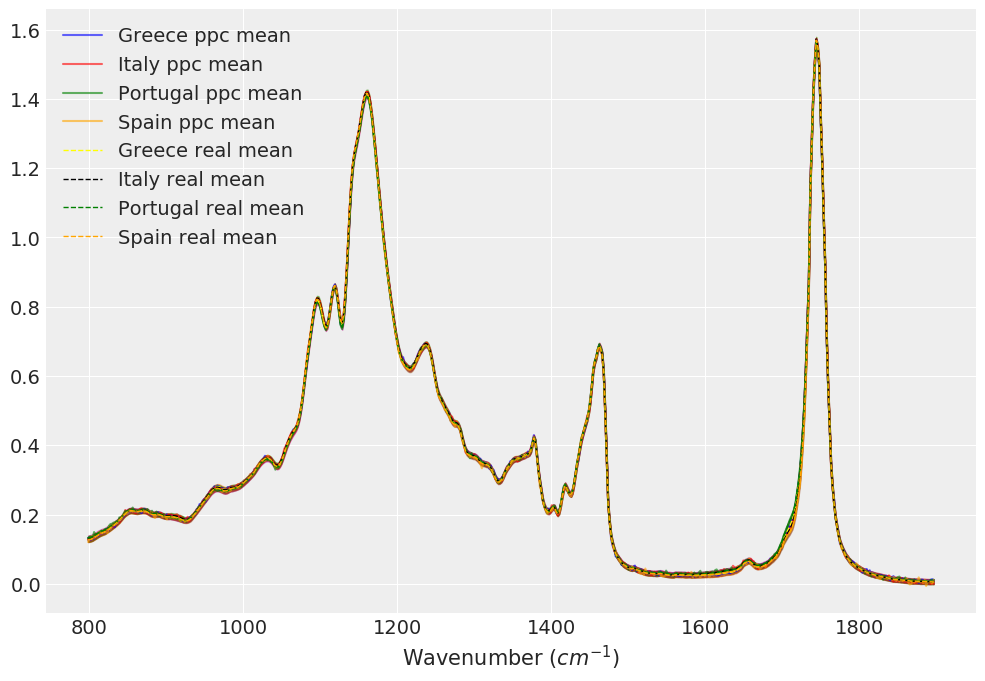

In [29]:
utl.plot_mean_vs_ppc(data_obj, ppc_class_lst)

# Real spectrum vs. posterior samples

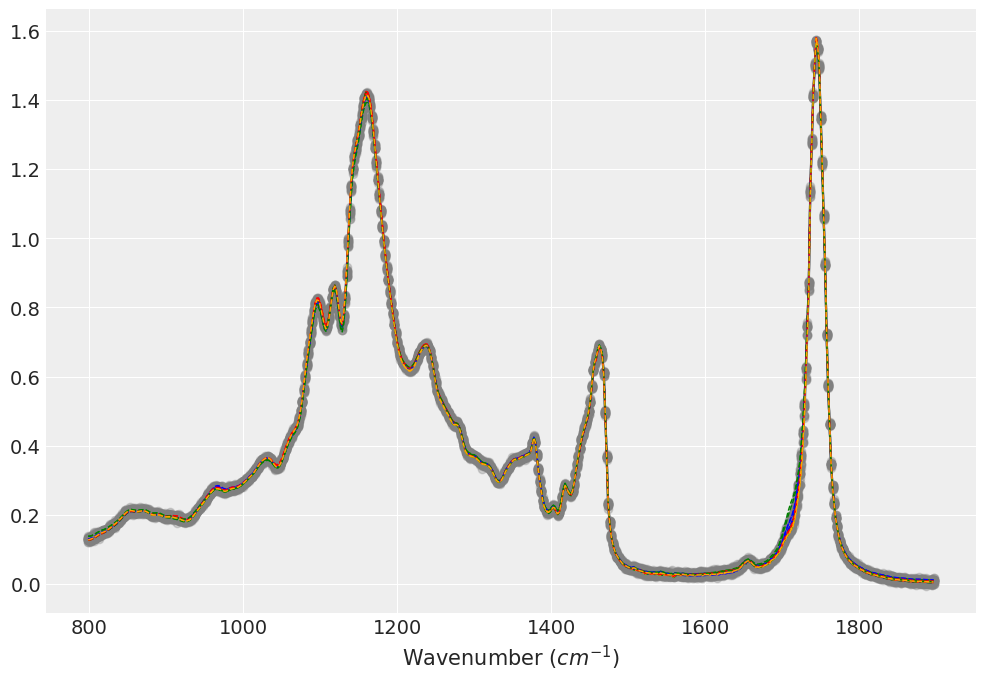

In [30]:
utl.plot_real_vs_ppc(data_obj, ppc_class_lst, 5)

# Save posterior samples to .csv file

In [31]:
utl.save_traces(data_obj, './ppc_samples_olive_oils.csv', 50, ppc_class_lst)